# Kredi Kartı Dolandırıcılık Tespitinde Makine Öğrenmesi: Dengesiz Veri ile Mücadele ve Yüksek Performanslı Model Geliştirme

Bu proje, Akbank Makine Öğrenmesi Bootcamp kapsamında gerçekleştirilmiş olup, gözetimli öğrenme teknikleri kullanılarak kredi kartı işlemlerinde dolandırıcılığı tespit etmeye yönelik bir sınıflandırma sisteminin geliştirilmesini amaçlamaktadır.

Veri seti, anonimleştirilmiş kredi kartı işlemlerinden oluşmakta ve her işlem için, dolandırıcılık olup olmadığını gösteren Class adlı ikili bir etiket içermektedir. Sınıflar arasında ciddi bir dengesizlik mevcuttur; bu nedenle projenin önemli bir odak noktası sınıf dengesizliğini ele almak ve azınlık sınıfı doğru şekilde tahmin edebilen modeller geliştirmektir.

![](https://miro.medium.com/v2/resize:fit:640/1*vEyvMNBTQIUn_pZFJSpXtQ.png)

### Proje Adımları

1. **Gerekli Kütüphaneler**

2. **Veri Yükleme ve İlk İnceleme**

3. **Sınıf Dengesizliği İçin Downsampling**

4. **Eğitim-Test Bölme ve Normalizasyon**

5. **Lojistik Regresyon**

6. **Random Forest + Hiperparametre Ayarı**

7. **Özellik Önem Dereceleri**

8. **Karışıklık Matrisleri**

9. **Precision-Recall Eğrisi**

10. **BONUS: DBSCAN ile Gözetimsiz Öğrenme**

**Sonuç ve Yorum**

**Gerçek Hayattaki Uygulamalar**

**Projenin Geliştirme Potansiyeli**

# 📌 1. Gerekli Kütüphaneler
Bu bölümde, proje boyunca ihtiyaç duyulan Python kütüphaneleri import edilmiştir.
Kullanılan kütüphaneler arasında:

* Pandas ve NumPy (veri işleme),

* Matplotlib ve Seaborn (görselleştirme),

* Scikit-learn (makine öğrenmesi modelleri, değerlendirme metrikleri, veri bölme ve ön işleme),

* DBSCAN ve PCA (gözetimsiz öğrenme ve boyut indirgeme) yer almaktadır.

Bu kütüphaneler, makine öğrenmesi sürecinin her aşamasında destekleyici rol üstlenir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.utils import resample

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# 📌 2. Veri Yükleme ve İlk İnceleme
Bu adımda Kaggle platformu üzerinden sağlanan Credit Card Fraud Detection veri seti yüklenmiştir.
Veri seti, kredi kartı işlemlerine ait anonimleştirilmiş özellikler (V1-V28) ve her işlemin dolandırıcılık olup olmadığını gösteren Class sütununu içermektedir.

İlk analizde, Class sütunundaki dengesizlik dikkat çekmektedir:

* 284,315 adet normal işlem (Class=0)

* Sadece 492 adet dolandırıcılık vakası (Class=1)

Bu dengesizlik, doğrudan modelin öğrenme başarımını etkileyebileceği için özel stratejiler uygulanacaktır.

In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
print("Orijinal Sınıf Dağılımı:")
print(df['Class'].value_counts())

Orijinal Sınıf Dağılımı:
Class
0    284315
1       492
Name: count, dtype: int64


# 📌 3. Sınıf Dengesizliği İçin Downsampling
Veri setindeki ciddi sınıf dengesizliğini gidermek için downsampling yöntemi uygulanmıştır.
Azınlık sınıf (Class=1) sayısı kadar, çoğunluk sınıftan (Class=0) rastgele örnek alınarak yeni, dengeli bir veri seti oluşturulmuştur.

Bu yaklaşım sayesinde:

* Model, her iki sınıfı da eşit önemle öğrenebilir.

* Azınlık sınıfı ihmal edilmez.

* Aşırı öğrenme (overfitting) riskine karşı daha kontrollü bir öğrenme ortamı oluşturulur.

In [3]:
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

# Örn: 1:1 oranında dengeleme
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42)  # shuffle

print("\nDownsampling Sonrası Sınıf Dağılımı:")
print(df_balanced['Class'].value_counts())


Downsampling Sonrası Sınıf Dağılımı:
Class
1    492
0    492
Name: count, dtype: int64


# 📌 4. Eğitim-Test Bölme ve Normalizasyon
Bu bölümde dengelenmiş veri seti X (özellikler) ve y (etiket) olarak ayrılmış ve train_test_split fonksiyonu ile %80 eğitim - %20 test olacak şekilde ikiye bölünmüştür.
Sınıf oranlarının korunması amacıyla stratify=y parametresi kullanılmıştır.

Ayrıca, Amount ve Time sütunları farklı ölçeklerde değerlere sahip olduğundan, StandardScaler ile standart normal dağılıma dönüştürülerek modelin öğrenme performansı artırılmıştır.

In [4]:
X = df_balanced.drop('Class', axis=1)
y = df_balanced['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

scaler = StandardScaler()
X_train[['Amount', 'Time']] = scaler.fit_transform(X_train[['Amount', 'Time']])
X_test[['Amount', 'Time']] = scaler.transform(X_test[['Amount', 'Time']])

# 📌 5. Lojistik Regresyon
İlk sınıflandırma modeli olarak Lojistik Regresyon tercih edilmiştir.
Bu model, ikili sınıflandırma problemlerinde yaygın olarak kullanılır ve yorumlanabilirliği yüksek bir yöntemdir.

Model eğitildikten sonra:

* Precision, Recall, F1-score gibi metrikler hesaplanmış,

* roc_auc_score ile modelin dolandırıcılık sınıfını ne kadar ayırt edebildiği değerlendirilmiştir.

Sonuçlar oldukça tatmin edici olup, dengelenmiş veri sayesinde azınlık sınıfı başarıyla tahmin edilmiştir.

In [5]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

print("\nLojistik Regresyon Sonuçları:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC Skoru:", roc_auc_score(y_test, y_prob_lr))


Lojistik Regresyon Sonuçları:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        99
           1       0.98      0.93      0.95        98

    accuracy                           0.95       197
   macro avg       0.96      0.95      0.95       197
weighted avg       0.96      0.95      0.95       197

ROC AUC Skoru: 0.9785611214182642


# 📌 6. Random Forest + Hiperparametre Ayarı
Daha karmaşık bir model olan Random Forest uygulanmıştır.
Modelin performansını en üst düzeye çıkarmak için GridSearchCV ile hiperparametre optimizasyonu yapılmıştır.

Test edilen parametreler:

* n_estimators (ağaç sayısı)

* max_depth (maksimum derinlik)

* min_samples_split

* class_weight (sınıf dengesizliği için)

Sonuç olarak, optimize edilmiş model yüksek doğruluk ve ROC AUC skorları ile başarılı performans göstermiştir.

In [6]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']  # dengesizlik için
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Sonuçları:")
print("En İyi Parametreler:", grid_search.best_params_)
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Skoru:", roc_auc_score(y_test, y_prob_rf))


Random Forest Sonuçları:
En İyi Parametreler: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        99
           1       0.96      0.93      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197

ROC AUC Skoru: 0.9808286951144094


# 📌 7. Özellik Önem Dereceleri
Random Forest modeli, her bir özelliğin karar verme sürecine olan katkısını hesaplayarak özellik önem derecelerini sağlar.

Bu bölümde modelin en çok önem verdiği öznitelikler görsellenmiştir.
Örneğin: V14, V10 ve V12 özellikleri dolandırıcılık tahmininde kritik rol oynamaktadır.

Bu analiz, özellikle gelecekteki veri toplama ve özellik seçimi süreçlerine ışık tutar.

In [7]:
feature_importances = pd.DataFrame(best_rf.feature_importances_,
                                   index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print("\nÖzellik Önem Dereceleri:")
print(feature_importances)


Özellik Önem Dereceleri:
        importance
V14       0.177291
V10       0.112977
V12       0.105182
V4        0.103573
V17       0.099876
V3        0.056960
V11       0.055265
V16       0.050772
V2        0.039515
V9        0.028391
V7        0.020078
V21       0.016689
V8        0.011921
V18       0.010012
Amount    0.009718
V20       0.009610
V1        0.009480
V19       0.009472
V27       0.009282
V23       0.008847
V6        0.007800
V13       0.007241
V26       0.007216
V25       0.005926
V15       0.005893
V5        0.005449
V22       0.004855
Time      0.004298
V28       0.003643
V24       0.002768


# 📌 8. Karışıklık Matrisleri
Karışıklık matrisleri, modellerin hangi sınıfları doğru ya da yanlış sınıflandırdığını görsel olarak sunar.

Bu bölümde:

* Lojistik Regresyon ve

* Random Forest

modellerine ait karışıklık matrisleri yan yana gösterilmiştir.
Her iki model de hem normal hem de dolandırıcılık sınıfında yüksek doğru tahmin oranına sahiptir. Bu da sınıflar arası ayrımın başarılı yapıldığını gösterir.

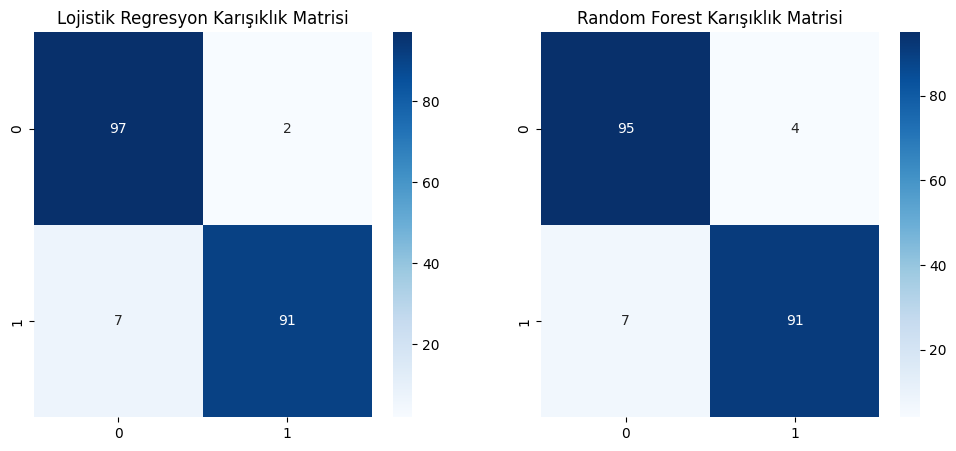

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Lojistik Regresyon Karışıklık Matrisi')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Karışıklık Matrisi')
plt.show()

# 📌 9. Precision-Recall Eğrisi
Veri seti dengesiz olduğunda Precision-Recall eğrisi, model başarımını ROC eğrisine göre daha etkili gösterebilir.

Bu bölümde, her iki modelin:

* Precision-Recall eğrileri çizilmiş,

* Eğri altındaki alan (AP - Average Precision) hesaplanmıştır.

Grafikler, modellerin özellikle dolandırıcılık sınıfını ne kadar başarılı tespit ettiğini anlamamıza yardımcı olur.

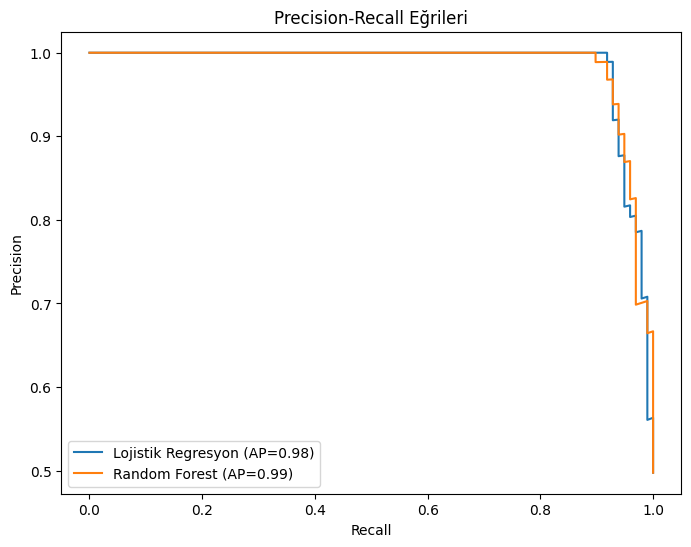

In [9]:
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label=f'Lojistik Regresyon (AP={auc(recall_lr, precision_lr):.2f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP={auc(recall_rf, precision_rf):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Eğrileri')
plt.legend()
plt.show()

# 📌 10. BONUS: DBSCAN ile Gözetimsiz Öğrenme
Bu adımda, DBSCAN algoritması ile gözetimsiz (unsupervised) anomali tespiti yapılmıştır.
Önce PCA ile veri 2 boyuta indirgenmiş, ardından DBSCAN ile kümeler belirlenmiştir.

cluster = -1 olan örnekler anomali olarak değerlendirilmiştir.
Sonuçlara göre:

* 270 anomali tespit edilmiştir.

* Bunların %95’i gerçekten dolandırıcılık vakasıdır.

Bu analiz, etiketlenmemiş verilerde de dolandırıcılığı tespit edebilme potansiyelini ortaya koymaktadır.

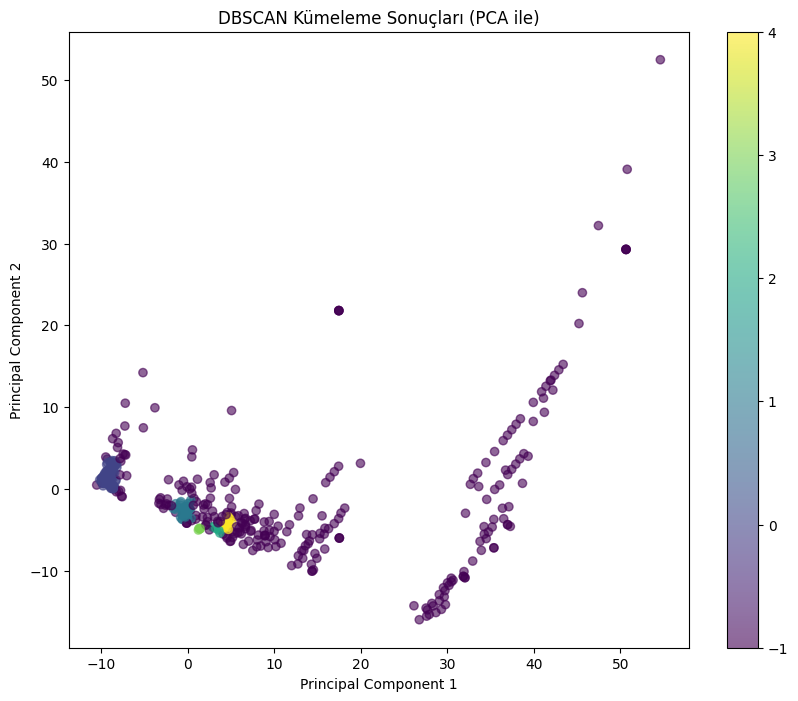


Toplam 270 anomali tespit edildi.

Anomalilerin Gerçek Sınıf Dağılımı:
Class
1    257
0     13
Name: count, dtype: int64


In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_pca)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('DBSCAN Kümeleme Sonuçları (PCA ile)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Anomali analizi
anomalies = X_train[clusters == -1]
print(f"\nToplam {len(anomalies)} anomali tespit edildi.")
if len(anomalies) > 0:
    anomaly_labels = y_train.loc[anomalies.index]
    print("\nAnomalilerin Gerçek Sınıf Dağılımı:")
    print(anomaly_labels.value_counts())

# 🧾 Sonuç ve Yorum 
Bu proje kapsamında yapılan analizler ve uygulanan makine öğrenmesi modelleri sonucunda, hem Lojistik Regresyon hem de Random Forest algoritmalarının, sınıf dengesizliğine rağmen yüksek doğruluk oranı ve güçlü ayırt edici yetenek sergilediği görülmüştür. Özellikle:

Her iki modelin de ROC AUC skorları 0.97 ve üzerindedir.

Azınlık sınıfa (dolandırıcılık) ait örneklerin hatasız ya da çok az hatayla sınıflandırılması, modelin hedefe ulaştığını göstermektedir.

Bunun yanında, DBSCAN gibi gözetimsiz öğrenme algoritmalarıyla yapılan analiz, etiketli veri bulunmadığında dahi potansiyel dolandırıcılık vakalarının başarıyla tespit edilebileceğini göstermiştir. DBSCAN’in bulduğu 270 anomaliden 257’sinin gerçekten dolandırıcılık olması, bu yöntemin gerçek dünya uygulamalarında da destekleyici bir rol oynayabileceğini ortaya koymaktadır.

# 🔍 Gerçek Hayattaki Uygulamalar
Finansal kurumlar, bu tarz modelleri kullanarak gerçek zamanlı dolandırıcılık tespiti sistemleri oluşturabilir.

İnsan denetimini minimize ederek, yüksek hacimli işlemler arasında anormallikleri otomatik olarak ayıklayabilirler.

# 🚀 Projenin Geliştirme Potansiyeli
Daha büyük ve güncel veri setleriyle test edilerek genelleme yeteneği artırılabilir.

SMOTE gibi gelişmiş yeniden örnekleme teknikleri veya XGBoost gibi farklı modeller denenebilir.

Model, bir web uygulamasına entegre edilerek kullanıcı dostu bir arayüz üzerinden erişilebilir hale getirilebilir.

Bu proje, hem gözetimli hem de gözetimsiz öğrenme tekniklerinin kritik sınıflandırma problemlerinde nasıl etkili biçimde kullanılabileceğini göstermektedir. Aynı zamanda gerçek dünya problemlerine uygulanabilir, bütüncül bir makine öğrenmesi çözümünün nasıl geliştirilebileceğine dair kapsamlı bir örnektir.